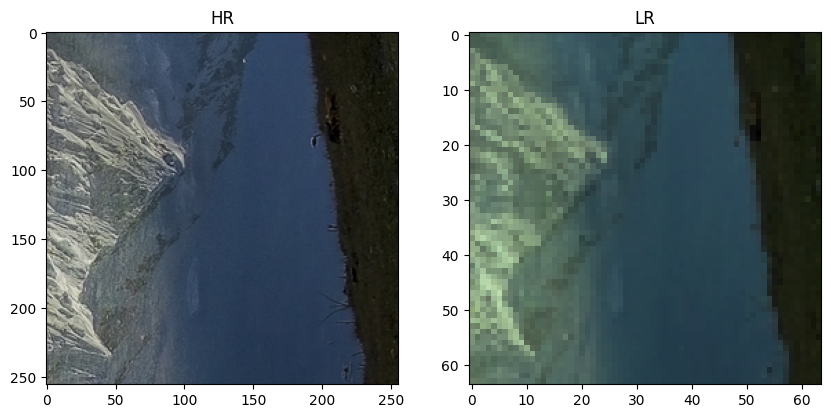

In [5]:
import random
import cv2
import numpy as np

def degrade_image(image, scale=4, output_shape=(256, 256)):
    """
    接受一张高分辨率(HR)图像，应用随机的退化操作生成对应的低分辨率(LR)图像。
    支持多种降采样比例、盲退化方式和数据增强，输入和输出格式可灵活选择。
    参数:
        image: 输入的HR图像。可以是PIL.Image对象、NumPy数组或torch.Tensor。
        scale: 降采样比例，例如2、4、8等。
        output_shape: 输出HR图像大小，格式为(H, W)。
    返回:
        (hr_image, lr_image): 元组，其中第一个是处理后的HR图像（裁剪或填充后为output_shape大小），
                              第二个是生成的对应LR图像，其尺寸为(output_shape除以scale)。
    """

    # 获取图像尺寸
    H, W, C = image.shape

    # 1. 数据增强：随机翻转
    if random.random() < 0.5:
        image = np.flip(image, axis=1)  # 水平翻转
    if random.random() < 0.5:
        image = np.flip(image, axis=0)  # 垂直翻转
    # 随机旋转90度的倍数
    rot_k = random.choice([0, 1, 2, 3])  # 0不旋转，1=90°, 2=180°, 3=270°
    if rot_k != 0:
        image = np.rot90(image, k=rot_k)
    # 更新尺寸
    H, W = image.shape[0], image.shape[1]

    # 随机裁剪并填充（保持尺寸不变）的数据增强
    if random.random() < 0.5:
        random_h = random.random() * 0.2
        random_w = random.random() * 0.2
        max_crop_h = max(1, int(random_h * H))
        max_crop_w = max(1, int(random_w * W))
        dx = random.randint(-max_crop_w, max_crop_w)  # 水平位移（正值表示向右移动）
        dy = random.randint(-max_crop_h, max_crop_h)  # 垂直位移（正值表示向下移动）
        # 计算裁剪区域
        left_crop = max(-dx, 0)  # 若dx为负，裁剪左侧 |dx| 列
        right_crop = max(dx, 0)  # 若dx为正，裁剪右侧 dx 列
        top_crop = max(-dy, 0)  # dy为负，裁剪上方 |dy| 行
        bottom_crop = max(dy, 0)  # dy为正，裁剪下方 dy 行
        rem_h = H - top_crop - bottom_crop  # 剩余高度
        rem_w = W - left_crop - right_crop  # 剩余宽度
        if rem_h > 0 and rem_w > 0:
            # 创建新图像并将裁剪后的原图放置到新图像中
            new_img = np.zeros((H, W, C), dtype=image.dtype)
            new_img[top_crop : top_crop + rem_h, left_crop : left_crop + rem_w] = (
                image[top_crop : top_crop + rem_h, left_crop : left_crop + rem_w]
            )
            image = new_img
            # 图像尺寸H, W保持不变

    # 增强后的HR图像作为输出高分辨率图像（不含模糊/噪声等退化）
    hr_img = image.copy()

    # 复制一份用于生成退化的LR图像
    lr_img = hr_img.copy()

    # 3. 盲退化策略：模糊（高斯模糊或运动模糊）
    blur_choice = random.random()
    if blur_choice < 0.33:
        # 高斯模糊
        sigma = random.uniform(0.5, 3.0)  # 随机选择模糊程度
        lr_img = cv2.GaussianBlur(lr_img, (0, 0), sigmaX=sigma, sigmaY=sigma)
    elif blur_choice < 0.66:
        # 运动模糊
        angle = random.choice([0, 45, 90, 135])  # 随机方向
        k = random.choice([3, 5, 7, 9, 11, 13, 15])  # 随机核长度（取奇数）
        if angle == 0:
            # 水平运动模糊
            kernel = np.zeros((1, k), np.float32)
            kernel[0, :] = 1.0 / k
        elif angle == 90:
            # 垂直运动模糊
            kernel = np.zeros((k, 1), np.float32)
            kernel[:, 0] = 1.0 / k
        elif angle == 45:
            # 45°对角线运动模糊
            kernel = np.zeros((k, k), np.float32)
            np.fill_diagonal(kernel, 1)
            kernel /= k
        else:
            # 135°对角线运动模糊
            kernel = np.zeros((k, k), np.float32)
            for i in range(k):
                kernel[i, k - 1 - i] = 1.0
            kernel /= k
        # 注意：OpenCV默认使用BGR，所以先转换
        lr_img_bgr = cv2.cvtColor(lr_img, cv2.COLOR_RGB2BGR)
        lr_img_bgr = cv2.filter2D(lr_img_bgr, -1, kernel)
        lr_img = cv2.cvtColor(lr_img_bgr, cv2.COLOR_BGR2RGB)
    # 如果 blur_choice >= 0.66，则不进行模糊

    # 盲退化策略：噪声（高斯噪声或泊松噪声）
    noise_choice = random.random()
    if noise_choice < 0.33:
        # 添加高斯噪声
        lr_float = lr_img.astype(np.float32)
        sigma_n = random.uniform(1, 10)
        noise = np.random.normal(0, sigma_n, lr_float.shape)
        lr_float += noise
        lr_img = np.clip(lr_float, 0, 255).astype(np.uint8)
    elif noise_choice < 0.66:
        # 添加泊松噪声
        lr_float = lr_img.astype(np.float32)
        vals = np.random.poisson(lr_float)
        lr_img = np.clip(vals, 0, 255).astype(np.uint8)
    # 若 noise_choice >= 0.66，则不加噪声

    # 盲退化策略：颜色偏移与伪影（对RGB三个通道随机缩放）
    lr_float = lr_img.astype(np.float32)
    factors = [random.uniform(0.9, 1.1) for _ in range(3)]
    for c in range(3):
        lr_float[:, :, c] *= factors[c]
    lr_img = np.clip(lr_float, 0, 255).astype(np.uint8)

    # 盲退化策略：随机下采样（降分辨率）
    # 注意：cv2.resize 的参数顺序为 (width, height)
    new_h = max(1, int(H // scale))
    new_w = max(1, int(W // scale))
    interp = random.choice([cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC])
    lr_img = cv2.resize(lr_img, (new_w, new_h), interpolation=interp)

    # 盲退化策略：JPEG压缩造成的伪影
    if random.random() < 0.5:
        quality = random.randint(30, 95)
        _, enc = cv2.imencode(
            ".jpg",
            cv2.cvtColor(lr_img, cv2.COLOR_RGB2BGR),
            [int(cv2.IMWRITE_JPEG_QUALITY), quality],
        )
        lr_img = cv2.imdecode(enc, cv2.IMREAD_COLOR)
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)

    # -------------------------------
    # 5. 最终裁剪与填充：保证 HR 图像为 output_shape，且裁剪起点对 scale 取整
    desired_h, desired_w = output_shape
    # 如果 HR 图像尺寸不足，则进行填充（使用黑色填充）
    pad_h = max(0, desired_h - hr_img.shape[0])
    pad_w = max(0, desired_w - hr_img.shape[1])
    if pad_h > 0 or pad_w > 0:
        hr_img = cv2.copyMakeBorder(
            hr_img, 0, pad_h, 0, pad_w, borderType=cv2.BORDER_CONSTANT, value=0
        )
        # 同步对 lr_img 进行填充前的更新：由于 lr_img 已经下采样，
        # 如果 HR 经过填充后尺寸变化，LR 需要重新计算尺寸（近似用当前插值方式）
        new_lr_h = hr_img.shape[0] // scale
        new_lr_w = hr_img.shape[1] // scale
        lr_img = cv2.resize(lr_img, (new_lr_w, new_lr_h), interpolation=interp)

    H, W, _ = hr_img.shape
    # 选择随机裁剪位置，确保裁剪区域大小为 output_shape
    max_top = H - desired_h
    max_left = W - desired_w
    top = random.randint(0, max_top)
    left = random.randint(0, max_left)
    # 调整裁剪起点为 scale 的倍数
    top = top - (top % scale)
    left = left - (left % scale)

    hr_img_cropped = hr_img[top : top + desired_h, left : left + desired_w]
    # 对应 LR 图像裁剪：由于 lr_img 为 HR 下采样后的图像，
    # 则裁剪起点为 (top//scale, left//scale)，裁剪尺寸为 (desired_h//scale, desired_w//scale)
    lr_top = top // scale
    lr_left = left // scale
    desired_h_lr = desired_h // scale
    desired_w_lr = desired_w // scale
    lr_img_cropped = lr_img[
        lr_top : lr_top + desired_h_lr, lr_left : lr_left + desired_w_lr
    ]
    # -------------------------------

    # 最终返回裁剪后的图像
    out_hr, out_lr = hr_img_cropped.astype(np.uint8), lr_img_cropped.astype(np.uint8)
    return out_hr, out_lr
import matplotlib.pyplot as plt

# Load a sample image for testing
try:
    sample_image = cv2.imread("DF2K/train/0002.png")  # 替换为你的图片路径
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
except FileNotFoundError:
    print("请确保 'DF2K/train/000001.png' 存在，或者替换为其他有效的图片路径。")
    sample_image = None

if sample_image is not None:
    # Generate degraded image
    hr_image, lr_image = degrade_image(sample_image, scale=4)

    # Display the images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(hr_image)
    plt.title("HR")

    plt.subplot(1, 2, 2)
    plt.imshow(lr_image)
    plt.title("LR")

    plt.show()
